## Load Dataset

In [1]:
import torchvision as thv
import os
import pickle
from torch.utils.data import Subset
import numpy as np

def get_mnist_dataset(root='./mnist_data'):
    # Check if the dataset already exists locally
    if os.path.exists(f'{root}/train_data.pkl') and os.path.exists(f'{root}/val_data.pkl'):
        print("Loading MNIST dataset from local storage...")
        with open(f'{root}/train_data.pkl', 'rb') as f:
            train = pickle.load(f)
        with open(f'{root}/val_data.pkl', 'rb') as f:
            val = pickle.load(f)
    else:
        print("Downloading MNIST dataset...")
        # Download the dataset
        train = thv.datasets.MNIST(root, download=True, train=True)
        val = thv.datasets.MNIST(root, download=True, train=False)
        
        # Save the dataset locally
        os.makedirs(root, exist_ok=True)
        with open(f'{root}/train_data.pkl', 'wb') as f:
            pickle.dump(train, f)
        with open(f'{root}/val_data.pkl', 'wb') as f:
            pickle.dump(val, f)

    print(f"Training dataset shape: {train.data.shape}, Number of targets: {len(train.targets)}")
    print(f"Validation dataset shape: {val.data.shape}, Number of targets: {len(val.targets)}")

    return train, val
    
def split_dataset(train, val):
    import torch
    import numpy as np
    from torch.utils.data import Subset

    # Define the number of classes and target sizes
    num_classes = 10
    target_train_size = 30000
    target_val_size = 5000

    # Initialize lists to hold the indices for the refined datasets
    train_indices = []
    val_indices = []

    # Iterate over each class and collect indices for the split
    for i in range(num_classes):
        # Get indices of all examples from class i in the training and validation sets
        train_class_indices = (train.targets == i).nonzero(as_tuple=True)[0]
        val_class_indices = (val.targets == i).nonzero(as_tuple=True)[0]

        # Convert indices to numpy arrays for shuffling
        train_class_indices_np = train_class_indices.numpy()
        val_class_indices_np = val_class_indices.numpy()

        # Shuffle indices
        np.random.shuffle(train_class_indices_np)
        np.random.shuffle(val_class_indices_np)

        # Calculate split indices, initially aiming to round up
        split_idx_train = (len(train_class_indices_np) + 1) // 2
        split_idx_val = (len(val_class_indices_np) + 1) // 2

        # Adjust split to avoid exceeding overall target sizes
        if len(train_indices) + split_idx_train > target_train_size:
            split_idx_train = target_train_size - len(train_indices)
        if len(val_indices) + split_idx_val > target_val_size:
            split_idx_val = target_val_size - len(val_indices)

        # Add indices to lists
        train_indices.extend(train_class_indices_np[:split_idx_train])
        val_indices.extend(val_class_indices_np[:split_idx_val])

        # Check if we have already reached the target sizes
        if len(train_indices) == target_train_size and len(val_indices) == target_val_size:
            break

    # Create refined datasets
    refined_train = Subset(train, train_indices)
    refined_val = Subset(val, val_indices)

    print(f"Refined training dataset size: {len(refined_train)}")
    print(f"Refined validation dataset size: {len(refined_val)}")

    return refined_train, refined_val


In [2]:
data_path = "./prob3_mnist_data"

train, val = get_mnist_dataset(data_path)
refined_train, refined_val = split_dataset(train, val)

# print("Train", train)
# print("Val", val)
# print("Refined Train", refined_train)
# print("Refined Val", refined_val)

Loading MNIST dataset from local storage...
Training dataset shape: torch.Size([60000, 28, 28]), Number of targets: 60000
Validation dataset shape: torch.Size([10000, 28, 28]), Number of targets: 10000
Refined training dataset size: 30000
Refined validation dataset size: 5000


In [3]:
# Normalize the datasets
def normalize_dataset(refined_train, refined_val):
    """
    (X / 255.0 - mean) / std
    """
    
    # Convert all training images to a single NumPy array
    train_images = np.array([
        refined_train.dataset.data[idx].float().cpu().numpy() for idx in refined_train.indices
    ])
    train_labels = np.array([
        refined_train.dataset.targets[idx].item() for idx in refined_train.indices
    ])
    
    # Convert all validation images to a single NumPy array
    val_images = np.array([
        refined_val.dataset.data[idx].float().cpu().numpy() for idx in refined_val.indices
    ])
    val_labels = np.array([
        refined_val.dataset.targets[idx].item() for idx in refined_val.indices
    ])
    
    # Scale pixel values to [0, 1]
    train_images /= 255.0
    val_images /= 255.0
    
    # Compute mean and std from the training data
    mean = train_images.mean()
    std = train_images.std()
    print(f"Computed Mean: {mean:.4f}, Computed Std: {std:.4f}")  # ~0.1307, ~0.3081 for MNIST
    
    # Normalize the training and validation images using training mean and std
    train_images_normalized = (train_images - mean) / std
    val_images_normalized = (val_images - mean) / std  # Use training mean and std for validation
    
    print(f"After Normalization - Train Images: min {train_images_normalized.min():.4f}, max {train_images_normalized.max():.4f}")
    print(f"After Normalization - Val Images: min {val_images_normalized.min():.4f}, max {val_images_normalized.max():.4f}")
    
    return (train_images, train_labels), (val_images, val_labels), mean, std
    # return (train_images_normalized, train_labels), (val_images_normalized, val_labels), mean, std


(train_normalized, train_labels), (val_normalized, val_labels), mean, std = normalize_dataset(refined_train, refined_val)

print("Train Normalized Shape:", train_normalized.shape)
print("Train Labels Shape:", train_labels.shape)
print("Validation Normalized Shape:", val_normalized.shape)
print("Validation Labels Shape:", val_labels.shape)

# Optionally, save the normalized datasets for future use
with open(f'{data_path}/train_normalized.pkl', 'wb') as f:
    pickle.dump((train_normalized, train_labels), f)

with open(f'{data_path}/val_normalized.pkl', 'wb') as f:
    pickle.dump((val_normalized, val_labels), f)

print("Normalized datasets have been saved successfully.")


Computed Mean: 0.1307, Computed Std: 0.3082
After Normalization - Train Images: min -0.4242, max 2.8201
After Normalization - Val Images: min -0.4242, max 2.8201
Train Normalized Shape: (30000, 28, 28)
Train Labels Shape: (30000,)
Validation Normalized Shape: (5000, 28, 28)
Validation Labels Shape: (5000,)
Normalized datasets have been saved successfully.


In [4]:
# Original version of normalizing
mean = train.data.float().mean() / 255.0
std = train.data.float().std() / 255.0
print(f"Mean: {mean}, Std: {std}")

transform = thv.transforms.Compose([
    thv.transforms.ToTensor(),
    thv.transforms.Normalize(mean=(mean,), std=(std,))
])

train = thv.datasets.MNIST(data_path, download=True, train=True, transform=transform)
val = thv.datasets.MNIST(data_path, download=True, train=False, transform=transform)
refined_train = thv.datasets.MNIST(data_path, download=True, train=True, transform=transform)
refined_val = thv.datasets.MNIST(data_path, download=True, train=False, transform=transform)

# Check data range
print(f"Min pixel value: {train.data.min()}, Max pixel value: {train.data.max()}")
print(f"Min pixel value: {val.data.min()}, Max pixel value: {val.data.max()}")
print(f"Min pixel value: {refined_train.data.min()}, Max pixel value: {refined_train.data.max()}")
print(f"Min pixel value: {refined_val.data.min()}, Max pixel value: {refined_val.data.max()}")

Mean: 0.13066047430038452, Std: 0.30810779333114624
Min pixel value: 0, Max pixel value: 255
Min pixel value: 0, Max pixel value: 255
Min pixel value: 0, Max pixel value: 255
Min pixel value: 0, Max pixel value: 255


## Plot and Validate Dataset

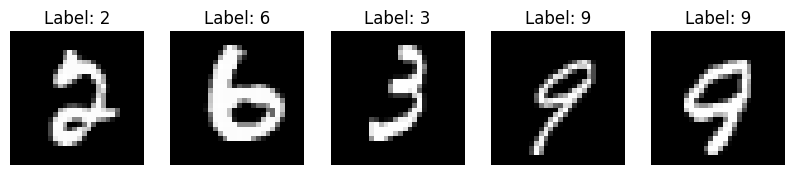

In [5]:
import matplotlib.pyplot as plt
import torch

def plot_images(dataset, num_images=6):
    # Making sure the dataset can be indexed directly
    assert hasattr(dataset, '__getitem__'), "Dataset must support indexing"

    indices = np.random.choice(len(dataset), num_images, replace=False)

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 3))
    
    if num_images == 1:
        axes = [axes]
    
    for ax, idx in zip(axes, indices):
        image, label = dataset[idx]
        
        # MNIST images are 1-channel images, need to be reshaped if in tensor form
        if isinstance(image, torch.Tensor):
            image = image.numpy().squeeze()  # Convert to numpy and remove extra dimensions
        
        ax.imshow(image, cmap='gray')
        ax.set_title(f"Label: {label}")
        ax.axis('off')

    plt.show()

plot_images(refined_train, num_images=5)

## Linear Layer

### Forward function
For $\beta$ samples, $\alpha$ input features, and $c$ output features, the forward function is 
$$h^{(l+1)} = h^{(l)} W^{\top} + b$$
where: $h^l \in R^{\beta \times \alpha}$, $W \in R^{c \times \alpha}$, $b \in R^c$, $h^{l+1} \in R^{\beta \times c}$

### Backward function:
$$\frac{\partial L}{\partial h^l} = \frac{\partial L}{\partial h^{l+1}} W$$
$$\frac{\partial L}{\partial W} = \frac{\partial L}{\partial h^{l+1}}^{\top} h^l$$
$$\frac{\partial L}{\partial b} = \sum_{i=1}^\beta \frac{\partial L}{\partial h_i^{l+1}}$$
where: $\frac{\partial L}{\partial h^{l+1}} \in R^{\beta \times c}$, $\frac{\partial L}{\partial W} \in R^{c \times \alpha}$, $\frac{\partial L}{\partial b} \in R^c$



## ReLU Layer

### Forward function
$$h^{(l+1)} = \max(0, h^{(l)})$$
where: $h^l \in R^{\beta \times \alpha}$, $h^{(l+1)} \in R^{\beta \times \alpha}$

### Backward function
$$\frac{\partial L}{\partial h^l} = \frac{\partial L}{\partial h^{l+1}} \odot \mathbb{1}(h^l > 0)$$
where: $\odot$ is element-wise multiplication, $\mathbb{1}$ is the indicator function

## Combined Softmax and Cross-entropy Loss Layer

### Forward function
$$h_k^{(l+1)} = \frac{e^{h_k^{(l)}}}{\sum_{k'} e^{h_{k'}^{(l)}}}$$
$$l(y) = -\log(h_y^{(l+1)})$$
For a mini-batch of size $\beta$, the loss is
$$l({y_i}_{i=1,...,\beta}) = -\frac{1}{\beta} \sum_{i=1}^{\beta} \log(h_y^{(l+1)})$$

Error is
$$\text{error} = \frac{1}{\beta} \sum_{i=1}^{\beta} \mathbb{1}(y \neq \text{argmax}_k(h_k^{(l+1)}))$$

### Backward function
$$\frac{\partial L}{\partial h^{(l)}} = \frac{1}{\beta} \sum_{i=1}^{\beta} \frac{\partial l(y_i)}{\partial h^{(l)}}$$
where: $\frac{\partial l(y_i)}{\partial h^{(l)}} = h^{(l+1)} - \mathbb{1}(y_i)$


## Check the backward pass of all three layers

In [6]:
from layers import linear_t

lin = linear_t(alpha=3, c=4)
h_l = np.array([[0.5, 1.5, 2.5], [-0.5, -1.5, -2.5]])  # alpha = 3, beta = 2
dh_lp1 = np.array([[0.1, 1, 2, 10], [0.1, 1, 2, 10]])  # c = 4, beta = 2
lin.W = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])  # c = 4, alpha = 3

h_lp1 = lin.forward(h_l)
lin.zero_grad()
dh_l = lin.backward(dh_lp1)

print(h_lp1)
print(dh_l)
print(lin.dW)
print(lin.db)

[[ 11.   24.5  38.   51.5]
 [-11.  -24.5 -38.  -51.5]]
[[118.1 131.2 144.3]
 [118.1 131.2 144.3]]
[[ 0.00000000e+00  1.38777878e-17 -1.38777878e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[ 0.2  2.   4.  20. ]


In [7]:
from layers import relu_t

relu = relu_t()
h_l = np.array([[0.5, 1.5, -2.5], [0.5, -1.5, 2.5]])  # alpha = 3, beta = 2
dh_lp1 = np.array([[0.3, 2, 1], [-1, -1, -1]])  

h_lp1 = relu.forward(h_l)
dh_l = relu.backward(dh_lp1)

print(h_lp1)
print(dh_l)

[[0.5 1.5 0. ]
 [0.5 0.  2.5]]
[[ 0.3  2.   0. ]
 [-1.  -0.  -1. ]]


In [8]:
from layers import softmax_cross_entropy_t

# Single sample
sce = softmax_cross_entropy_t()
h_l = np.array([1, 2, 3])
y = np.array([2])
dh_lp1 = np.array([0.1, 1, 2])

h_lp1, ell, error = sce.forward(h_l, y)
dh_l = sce.backward(dh_lp1, y)

print("\nSingle sample")
print(h_lp1)
print(ell)
print(error)
print(dh_l)

# Batched samples
sce = softmax_cross_entropy_t()
h_l = np.array([[1, 2, 3], [2, -1, 3]])
y = np.array([2, 1])
dh_lp1 = np.array([[0.1, 1, 2], [0.1, 1, 2]])

h_lp1, ell, error = sce.forward(h_l, y)
dh_l = sce.backward(dh_lp1, y)

print("\nBatched")
print(h_lp1)
print(ell)
print(error)
print(dh_l)


Single sample
[[0.09003057 0.24472847 0.66524096]]
0.40760596444437897
0.0
[[ 0.09003057  0.24472847 -0.33475904]]

Batched
[[0.09003057 0.24472847 0.66524096]
 [0.26538793 0.01321289 0.72139918]]
2.367084302855887
0.5
[[ 0.04501529  0.12236424 -0.16737952]
 [ 0.13269396 -0.49339356  0.36069959]]


### Since all three layers have been validated and compared with PyTorch, we can continue to (f)

## Training, Visualization and Validation

In [9]:
# Helper functions for visualization

import matplotlib.pyplot as plt
from ipywidgets import Output

# Helper functions to plot loss and error using a separate Output widget
def plot_loss_error(train_error_results, train_loss_results, val_error_results, val_loss_results, plot_output):
    """
    Plots the validation error and validation loss over iterations.
    Updates the plot in the provided Output widget.

    Args:
        val_error_results (list): List of validation error values over iterations.
        val_loss_results (list): List of validation loss values over iterations.
        plot_output (Output): IPython Output widget to render the plots.
    """
    iterations = list(range(0, len(val_loss_results) * 1000, 1000))  # Assuming evaluation every 1000 steps

    with plot_output:
        # Clear the previous plot to avoid stacking
        clear_output(wait=True)
        plt.figure(figsize=(12, 10))

        # Training loss
        plt.subplot(2, 2, 1)
        plt.plot(iterations, train_loss_results, label='Training Loss', color='blue', marker='o')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title('Training Loss over Iterations')
        plt.grid(True)
        plt.legend()

        # Training error
        plt.subplot(2, 2, 2)
        plt.plot(iterations, train_error_results, label='Training Error', color='red', marker='o')
        plt.xlabel('Iterations')
        plt.ylabel('Error')
        plt.title('Training Error over Iterations')
        plt.grid(True)
        plt.legend()

        # Validation loss
        plt.subplot(2, 2, 3)
        plt.plot(iterations, val_loss_results, label='Validation Loss', color='blue', marker='o')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title('Validation Loss over Iterations')
        plt.grid(True)
        plt.legend()

        # Validation error
        plt.subplot(2, 2, 4)
        plt.plot(iterations, val_error_results, label='Validation Error', color='red', marker='o')
        plt.xlabel('Iterations')
        plt.ylabel('Error')
        plt.title('Validation Error over Iterations')
        plt.grid(True)
        plt.legend()

        # Adjust layout and show the updated plots
        plt.tight_layout()
        plt.show()
        
# Function to print validation metrics using a separate Output widget
def print_validation_metrics(iteration, train_loss, train_error, val_loss, val_error, validation_output):
    with validation_output:
        print(f"Iter: {iteration}\tTrain Loss: {train_loss:.4f}, Train Err: {train_error:.4f}\tVal Loss: {val_loss:.4f}, Val Err: {val_error:.4f}")

### NumPy Implementation

In [10]:
## NumPy Implementation
from IPython.display import clear_output
from tqdm.notebook import tqdm
from IPython.display import clear_output, display
from IPython.display import display, HTML
from layers import linear_t, relu_t, softmax_cross_entropy_t


# Load the normalized datasets
with open(f'{data_path}/train_normalized.pkl', 'rb') as f:
    (train_normalized, train_labels) = pickle.load(f)
with open(f'{data_path}/val_normalized.pkl', 'rb') as f:
    (val_normalized, val_labels) = pickle.load(f)

# Verify dataset
print(f"Train Normalized Data - Mean: {train_normalized.mean():.4f}, Std: {train_normalized.std():.4f}")  # Should be ~0.0, ~1.0
print(f"Validation Normalized Data - Mean: {val_normalized.mean():.4f}, Std: {val_normalized.std():.4f}")  # Should be close to 0.0, 1.0

# Random seed for reproducibility
np.random.seed(42)

# Initialize all the layers
l1, l2, l3 = linear_t(), relu_t(), softmax_cross_entropy_t()
net = [l1, l2, l3]

# Define training parameters
lr = 0.1
lr_decay_rate = 0.99995
max_iters = 10000
batch_size = 32
# np.random.seed(42)

# Create separate Output widgets for plotting and printing validation metrics
plot_output = Output()
validation_output = Output()
display(plot_output)
display(validation_output)

process_bar = tqdm(range(max_iters))
val_error_results = []
val_loss_results = []
train_error_results = []
train_loss_results = []

# Train for at least 1000 iterations
for t in range(max_iters):
    # 1. Sample a mini-batch of size = 32
    # Each image in the mini-batch is chosen uniformly randomly from the training dataset
    indices = np.random.choice(len(train_normalized), batch_size, replace=False)
    x = train_normalized[indices]
    x = x.reshape(x.shape[0], -1)  # (32, 28, 28) reshaped to (32, 784)
    y = train_labels[indices]  # (32,)
    
    # 2. Zero gradient buffer
    for l in net:
        l.zero_grad()
    
    # 3. Forward pass
    h1 = l1.forward(x)  # (32, 10), l1.W: (10, 784), l1.b: (10,)
    h2 = l2.forward(h1)  # (32, 10)
    _, ell, error = l3.forward(h2, y)  # (32, 10), scalar, scalar, l3.y: (32, 1), l3.h and l3.h_lp1: (32, 10)
    
    # 4. Backward pass
    dh2 = l3.backward()  # (32, 10)
    dh1 = l2.backward(dh2)  # (32, 10)
    dx = l1.backward(dh1)  # (32, 784)
    
    # 5. Gather backprop gradients
    dW, db = l1.dW, l1.db  # (10, 784), (10,)
    
    # 6. Print some quantities for logging and debugging
    process_bar.update(1)
    # print(t, ell, error)
    # print(t, np.linalg.norm(dW/l1.W), np.linalg.norm(db/l1.b))
    process_bar.set_description(
        f"Iter: {t:4d}, LR: {lr:.6f}, Loss: {ell.item():.4f}, Error: {error:.4f}, "
        f"dW/W Norm: {np.linalg.norm(dW/l1.W):.4f}, "
        f"db/b Norm: {np.linalg.norm(db/l1.b):.4f}"
    )
    
    # 7. One step of SGD
    l1.W -= lr * dW
    l1.b -= lr * db

    # 8. Learning rate decay
    lr *= lr_decay_rate

    # 9. Every 1000 iterations, evaluate the model on the validation set
    if t % 1000 == 0 or t == max_iters - 1:
        # Evaluate the model on the validation set
        val_losses = []
        val_errors = []
        train_losses = []
        train_errors = []
        for idx in range(len(val_normalized)):
            x_val = val_normalized[idx].reshape(1, -1)  # Shape: (1, 784)
            x_train = train_normalized[idx].reshape(1, -1)  # Shape: (1, 784)
            y_val = val_labels[idx].reshape(1,)        # Shape: (1,)
            y_train = train_labels[idx].reshape(1,)    # Shape: (1,)

            h1_val = l1.forward(x_val)
            h1_train = l1.forward(x_train)
            h2_val = l2.forward(h1_val)
            h2_train = l2.forward(h1_train)
            _, ell_val, error_val = l3.forward(h2_val, y_val)
            _, ell_train, error_train = l3.forward(h2_train, y_train)

            val_losses.append(ell_val.item())
            val_errors.append(error_val)
            train_losses.append(ell_train.item())
            train_errors.append(error_train)

        # Compute the average loss and error
        val_loss = np.mean(val_losses)
        val_error = np.mean(val_errors)
        val_error_results.append(val_error)
        val_loss_results.append(val_loss)
        train_loss = np.mean(train_losses)
        train_error = np.mean(train_errors)
        train_error_results.append(train_error)
        train_loss_results.append(train_loss)

        # Plot the validation loss and error
        plot_loss_error(train_error_results, train_loss_results, val_error_results, val_loss_results, plot_output)

        # Print the validation loss and error below the progress bar
        print_validation_metrics(t, train_loss, train_error, val_loss, val_error, validation_output)

        # Early stopping conditions
        if val_loss < 0.1:
            with validation_output:
                print("\nStopping training as validation loss is below 0.1")
            break
        if val_error < 0.05:
            with validation_output:
                print("\nStopping training as validation error is below 0.05")
            break

# Close the progress bar when done
process_bar.close()


Train Normalized Data - Mean: 0.1307, Std: 0.3082
Validation Normalized Data - Mean: 0.1329, Std: 0.3108


Output()

Output()

  0%|          | 0/10000 [00:00<?, ?it/s]

C:\Users\Bw Jiang\AppData\Local\Temp\ipykernel_27408\1328028627.py:76: RuntimeWarning: divide by zero encountered in divide
  f"Iter: {t:4d}, LR: {lr:.6f}, Loss: {ell.item():.4f}, Error: {error:.4f}, "


### PyTorch Implementation


In [11]:
# PyTorch Comparison
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import ExponentialLR
from IPython.display import clear_output, display
from IPython.display import display, HTML


# Convert NumPy arrays to PyTorch tensors
train_normalized_tensor = torch.from_numpy(train_normalized).float()  # Shape: (30000, 28, 28)
train_labels_tensor = torch.from_numpy(train_labels).long()           # Shape: (30000,)
val_normalized_tensor = torch.from_numpy(val_normalized).float()      # Shape: (5000, 28, 28)
val_labels_tensor = torch.from_numpy(val_labels).long()               # Shape: (5000,)
train_normalized_tensor = train_normalized_tensor.view(train_normalized_tensor.size(0), -1)  # Shape: (30000, 784)
val_normalized_tensor = val_normalized_tensor.view(val_normalized_tensor.size(0), -1)        # Shape: (5000, 784)

# Random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Initialize layers
l1_torch, l2_torch, l3_torch = nn.Linear(784, 10), nn.ReLU(), nn.CrossEntropyLoss()
net_torch = [l1_torch, l2_torch, l3_torch]

# Learning settings
lr = 0.1
lr_decay_rate = 0.99995
max_iters = 10000
batch_size = 32
optimizer = torch.optim.SGD(l1_torch.parameters(), lr=lr)
scheduler = ExponentialLR(optimizer, gamma=lr_decay_rate)

# Create separate Output widgets for plotting and printing validation metrics
plot_output = Output()
validation_output = Output()
display(plot_output)
display(validation_output)

process_bar = tqdm(range(max_iters))

val_error_results = []
val_loss_results = []
train_error_results = []
train_loss_results = []

# Train iteration
for t in range(max_iters):
    process_bar.update(1)
    # 1. Sample a mini-batch of size = 32
    indices = np.random.choice(len(train_normalized_tensor), batch_size, replace=False)
    x = train_normalized_tensor[indices]
    x = x.reshape(x.shape[0], -1)  # (32, 28, 28) reshaped to (32, 784)
    y = train_labels_tensor[indices]  # (32,)
    
    # 2. Zero gradient buffer
    optimizer.zero_grad()
    
    # 3. Forward pass
    h1 = l1_torch(x)  # (32, 10)
    h2 = l2_torch(h1)  # (32, 10)
    ell = l3_torch(h2, y)  # scalar
    
    # 4. Backward pass
    ell.backward()
    
    # 5. Print some quantities for logging and debugging
    current_lr = optimizer.param_groups[0]['lr']
    process_bar.set_description(
        f"Iter: {t:4d}, LR: {current_lr:.6f}, Loss: {ell.item():.4f}, "
        f"dW/W Norm: {torch.norm(l1_torch.weight.grad / l1_torch.weight).item():.4f}, "
        f"db/b Norm: {torch.norm(l1_torch.bias.grad / l1_torch.bias).item():.4f}"
    )
    
    # 6. One step of SGD
    optimizer.step()

    # 7. Step the scheduler to adjust the learning rate
    scheduler.step()

    # 8. Every 1000 iterations, evaluate the model on the validation set
    if t % 1000 == 0 or t == max_iters - 1:
        # Evaluate the model on the validation set
        train_losses = []
        train_errors = []
        val_losses = []
        val_errors = []
        with torch.no_grad():
            # Process validation data in batches to speed up evaluation
            val_batch_size = 1000  # Adjust based on memory constraints
            num_val_batches = len(val_normalized_tensor) // val_batch_size
            for i in range(num_val_batches):
                start_idx = i * val_batch_size
                end_idx = start_idx + val_batch_size
                x_val = val_normalized_tensor[start_idx:end_idx]  # Shape: (batch_size, 784)
                y_val = val_labels_tensor[start_idx:end_idx]      # Shape: (batch_size,)
                x_train = train_normalized_tensor[start_idx:end_idx]  # Shape: (batch_size, 784)
                y_train = train_labels_tensor[start_idx:end_idx]      # Shape: (batch_size,)

                h1_val = l1_torch(x_val)
                h1_train = l1_torch(x_train)
                h2_val = l2_torch(h1_val)
                h2_train = l2_torch(h1_train)
                ell_val = l3_torch(h2_val, y_val)
                ell_train = l3_torch(h2_train, y_train)

                train_losses.append(ell_train.item())
                train_errors.append((h2_train.argmax(dim=1) != y_train).float().mean().item())
                val_losses.append(ell_val.item())
                val_errors.append((h2_val.argmax(dim=1) != y_val).float().mean().item())

        # Compute the average loss and error
        val_loss = np.mean(val_losses)
        val_error = np.mean(val_errors)
        val_error_results.append(val_error)
        val_loss_results.append(val_loss)
        train_loss = np.mean(train_losses)
        train_error = np.mean(train_errors)
        train_error_results.append(train_error)
        train_loss_results.append(train_loss)

        # Plot the validation loss and error
        plot_loss_error(train_error_results, train_loss_results, val_error_results, val_loss_results, plot_output)

        # Print the validation loss and error below the progress bar
        print_validation_metrics(t, train_loss, train_error, val_loss, val_error, validation_output)

        # Early stopping conditions
        if val_loss < 0.1:
            with validation_output:
                print("\nStopping training as validation loss is below 0.1")
            break
        if val_error < 0.05:
            with validation_output:
                print("\nStopping training as validation error is below 0.05")
            break

# Close the progress bar when done
process_bar.close()
    

Output()

Output()

  0%|          | 0/10000 [00:00<?, ?it/s]

## Validation (already down in the previous steps)

In [13]:
# # For NumPy Implementation
# def validate_numpy(w, b):
#     # TODO
#     # 1. Iterate over mini-batches from the validation dataset
#     # Note that this should not be done randomly , we want to check every image only once
#     loss, tot_error = 0, 0
#     for i in range(0, 5000, 32):
#         x, y = refined_val.data[i:i+32], refined_val.targets[i:i+32]
    
#     # 2. Compute forward pass and error
#     h1 = l1.forward(x)  # (32, 10)
#     h2 = l2.forward(h1)  # (32, 10)
#     _, ell, error = l3.forward(h2, y)  # (32, 10), scalar, scalar, l3.y: (32, 1), l3.h and l3.h_lp1: (32, 10)

#     # 3. Accumulate loss and error
#     loss += ell
#     tot_error += error

#     return loss, tot_error


In [ ]:

# # For PyTorch Implementation
# def validate_pytorch(w, b):
#     # TODO
#     # 1. Iterate over mini-batches from the validation dataset
#     # Note that this should not be done randomly , we want to check every image only once
#     loss, tot_error = 0, 0
#     for i in range(0, 5000, 32):
#         x, y = refined_val.data[i:i+32], refined_val.targets[i:i+32]
    
#     # 2. Compute forward pass and error
#     h1 = l1_torch.forward(x)  # (32, 10)
#     h2 = l2_torch.forward(h1)  # (32, 10)
#     _, ell, error = l3_torch.forward(h2, y)  # (32, 10), scalar, scalar, l3.y: (32, 1), l3.h and l3.h_lp1: (32, 10)

#     # 3. Accumulate loss and error
#     loss += ell
#     tot_error += error

#     return loss, tot_error
